# Deep Learning vs Statistical Models for VaR Prediction
## MENA Region Stock Market Analysis

This notebook implements and compares deep learning models (ANN, LSTM, CNN) with statistical models (ARIMA, SARIMA) for predicting Value-at-Risk in MENA stock indices.

In [29]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Statsmodels for ARIMA/SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("Libraries imported successfully!")

Libraries imported successfully!


In [30]:
# ==================== DATA LOADING & PREPROCESSING ====================

class DataPreprocessor:
    def __init__(self, lookback=60):
        self.lookback = lookback
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.data_stats = {}
    
    def load_data(self, filepath):
        """Load CSV data and handle formatting"""
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        df['Price'] = pd.to_numeric(df['Price'].str.replace(',', ''), errors='coerce')
        return df
    
    def handle_missing_values(self, df, method='forward_fill'):
        """
        Methods:
        - 'forward_fill': Use last known price (default, best for market holidays/weekends)
        - 'interpolate': Linear interpolation between values
        - 'drop': Remove rows with missing values
        """
        df = df.copy()
        missing_before = df['Price'].isna().sum()
        
        if missing_before == 0:
            print(f"✓ No missing values found")
            return df
        
        print(f"⚠ Missing values found: {missing_before} ({missing_before/len(df)*100:.2f}%)")
        
        if method == 'forward_fill':
            # Forward fill with backward fill for any remaining NaNs at the start
            df['Price'] = df['Price'].fillna(method='ffill').fillna(method='bfill')
            print(f"✓ Applied forward fill (best for market data)")
        elif method == 'interpolate':
            # Linear interpolation - good when prices jump unexpectedly
            df['Price'] = df['Price'].interpolate(method='linear')
            print(f"✓ Applied linear interpolation")
        elif method == 'drop':
            # Drop rows with missing prices
            df = df.dropna(subset=['Price']).reset_index(drop=True)
            print(f"✓ Dropped {missing_before} rows with missing prices")
        
        remaining_missing = df['Price'].isna().sum()
        if remaining_missing > 0:
            df = df.dropna(subset=['Price']).reset_index(drop=True)
            print(f"✓ Dropped remaining {remaining_missing} missing values")
        
        return df
    
    def detect_outliers(self, df, window=20, std_threshold=3):
        """Detect and report potential outliers using rolling statistics"""
        df = df.copy()
        df['Returns'] = df['Price'].pct_change() * 100
        
        # Calculate rolling statistics
        rolling_mean = df['Returns'].rolling(window=window).mean()
        rolling_std = df['Returns'].rolling(window=window).std()
        
        # Identify outliers (beyond 3 standard deviations)
        outlier_threshold_upper = rolling_mean + (std_threshold * rolling_std)
        outlier_threshold_lower = rolling_mean - (std_threshold * rolling_std)
        
        outliers = (df['Returns'] > outlier_threshold_upper) | (df['Returns'] < outlier_threshold_lower)
        num_outliers = outliers.sum()
        
        if num_outliers > 0:
            print(f"⚠ Detected {num_outliers} potential outliers ({num_outliers/len(df)*100:.2f}%)")
            outlier_dates = df[outliers]['Date'].dt.strftime('%Y-%m-%d').tolist()
            print(f"  Outlier dates: {', '.join(outlier_dates[:5])}" + 
                  (f" ... and {num_outliers-5} more" if num_outliers > 5 else ""))
        else:
            print(f"✓ No significant outliers detected")
        
        return df
    
    def calculate_returns(self, prices):
        """Calculate logarithmic returns"""
        returns = np.log(prices / prices.shift(1)).dropna()
        return returns
    
    def create_sequences(self, data, lookback):
        """Create sequences for LSTM"""
        X, y = [], []
        for i in range(len(data) - lookback):
            X.append(data[i:i + lookback])
            y.append(data[i + lookback])
        return np.array(X), np.array(y)
    
    def preprocess_for_deeplearning(self, df):
        """Preprocess data for deep learning models"""
        prices = df['Price'].values.reshape(-1, 1)
        returns = self.calculate_returns(df['Price']).values.reshape(-1, 1)
        
        # Normalize returns
        returns_scaled = self.scaler.fit_transform(returns)
        
        # Create sequences
        X, y = self.create_sequences(returns_scaled, self.lookback)
        
        return X, y, returns_scaled
    
    def split_train_test(self, X, y, test_size=0.2):
        """Split data into train and test sets"""
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        return X_train, X_test, y_train, y_test
    
    def get_data_summary(self, df, name=""):
        """Get comprehensive data summary"""
        print(f"\n{'='*60}")
        print(f"DATA SUMMARY: {name}")
        print(f"{'='*60}")
        print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
        print(f"Total Records: {len(df)}")
        print(f"Missing Values: {df['Price'].isna().sum()}")
        print(f"\nPrice Statistics:")
        print(f"  Min:    ${df['Price'].min():.2f}")
        print(f"  Max:    ${df['Price'].max():.2f}")
        print(f"  Mean:   ${df['Price'].mean():.2f}")
        print(f"  Median: ${df['Price'].median():.2f}")
        print(f"  Std:    ${df['Price'].std():.2f}")
        
        returns = self.calculate_returns(df['Price'])
        print(f"\nReturn Statistics (Log Returns):")
        print(f"  Mean:   {returns.mean()*100:.4f}%")
        print(f"  Std:    {returns.std()*100:.4f}%")
        print(f"  Min:    {returns.min()*100:.4f}%")
        print(f"  Max:    {returns.max()*100:.4f}%")
        print(f"  Skew:   {returns.skew():.4f}")
        print(f"  Kurt:   {returns.kurtosis():.4f}")
        print(f"{'='*60}\n")

print("✓ DataPreprocessor class created!")

✓ DataPreprocessor class created!


In [31]:
# ==================== MODEL EVALUATOR ====================

class ModelEvaluator:
    """Evaluate model performance with comprehensive metrics"""
    
    @staticmethod
    def calculate_metrics(y_true, y_pred):
        """Calculate evaluation metrics"""
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}
    
    @staticmethod
    def calculate_var(returns, confidence_level=0.95):
        """Calculate VaR using historical simulation"""
        var = np.percentile(returns, (1 - confidence_level) * 100)
        return var
    
    @staticmethod
    def calculate_cvar(returns, confidence_level=0.95):
        """Calculate Conditional Value at Risk (Expected Shortfall)"""
        var = np.percentile(returns, (1 - confidence_level) * 100)
        cvar = returns[returns <= var].mean()
        return cvar
    
    @staticmethod
    def confusion_matrix_var(returns, predicted_var, confidence_level=0.95, threshold=None):
        """
        Create confusion matrix for VaR predictions
        Compares actual vs predicted risk events
        """
        if threshold is None:
            threshold = np.percentile(returns, (1 - confidence_level) * 100)
        
        # Actual events: returns below threshold
        actual_events = (returns < threshold).astype(int)
        # Predicted events: returns below predicted VaR
        predicted_events = (returns < predicted_var).astype(int)
        
        # Confusion matrix
        TP = np.sum((actual_events == 1) & (predicted_events == 1))
        TN = np.sum((actual_events == 0) & (predicted_events == 0))
        FP = np.sum((actual_events == 0) & (predicted_events == 1))
        FN = np.sum((actual_events == 1) & (predicted_events == 0))
        
        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        return {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    @staticmethod
    def plot_confusion_matrix(cm_dict, model_name, ax=None):
        """Plot confusion matrix for VaR predictions"""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))
        
        cm = np.array([[cm_dict['TN'], cm_dict['FP']], 
                       [cm_dict['FN'], cm_dict['TP']]])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Risk', 'Risk'], 
                    yticklabels=['No Risk', 'Risk'],
                    cbar=False, ax=ax, annot_kws={'size': 12, 'weight': 'bold'})
        
        ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name} - VaR Confusion Matrix\n(Confidence: 95%)', 
                     fontsize=12, fontweight='bold')
        
        # Add metrics text
        metrics_text = f"Accuracy: {cm_dict['accuracy']:.3f}\nPrecision: {cm_dict['precision']:.3f}\n"
        metrics_text += f"Recall: {cm_dict['recall']:.3f}\nF1: {cm_dict['f1_score']:.3f}"
        ax.text(1.4, 0.5, metrics_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='center',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

print("✓ ModelEvaluator class created with VaR and confusion matrix!")

✓ ModelEvaluator class created with VaR and confusion matrix!


In [32]:
# ==================== ARTIFICIAL NEURAL NETWORK ====================

class ANNModel:
    """Artificial Neural Network for return prediction"""
    
    def __init__(self, input_shape):
        self.model = Sequential([
            Dense(128, activation='relu', input_shape=(input_shape,)),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='linear')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the ANN model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ ANNModel class created!")

✓ ANNModel class created!


In [33]:
# ==================== LSTM NEURAL NETWORK ====================

class LSTMModel:
    """Long Short-Term Memory Network for sequential prediction"""
    
    def __init__(self, input_shape):
        self.model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(input_shape[0], input_shape[1])),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1, activation='linear')
        ])
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the LSTM model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ LSTMModel class created!")

✓ LSTMModel class created!


In [34]:
# ==================== CONVOLUTIONAL NEURAL NETWORK ====================

class CNNModel:
    """Convolutional Neural Network adapted for time series"""
    
    def __init__(self, input_shape):
        # Reshape input for CNN: (samples, timesteps, features, 1)
        self.model = Sequential([
            # First Conv Block
            keras.layers.Conv1D(32, 3, padding='same', activation='relu', input_shape=(input_shape[0], input_shape[1])),
            keras.layers.Conv1D(32, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Second Conv Block
            keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
            keras.layers.Conv1D(64, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Third Conv Block
            keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            keras.layers.Conv1D(128, 3, activation='relu'),
            keras.layers.MaxPooling1D(2),
            Dropout(0.25),
            
            # Dense layers
            keras.layers.Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        
        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        self.history = None
        self.training_time = 0
    
    def train(self, X_train, y_train, epochs=50, batch_size=32, validation_split=0.1):
        """Train the CNN model"""
        import time
        start_time = time.time()
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=[early_stop],
            verbose=0
        )
        
        self.training_time = time.time() - start_time
        return self.history
    
    def predict(self, X):
        """Make predictions"""
        return self.model.predict(X, verbose=0)
    
    def get_summary(self):
        """Get model summary"""
        return self.model.summary()

print("✓ CNNModel class created!")

✓ CNNModel class created!


In [35]:
# ==================== ARIMA MODEL ====================

class ARIMAModel:
    """ARIMA model for time series forecasting"""
    
    def __init__(self, order=(5, 1, 2)):
        self.order = order
        self.model = None
        self.fitted_model = None
        self.training_time = 0
        self.predictions = []
    
    def fit(self, returns):
        """Fit ARIMA model"""
        import time
        start_time = time.time()
        
        self.model = ARIMA(returns, order=self.order)
        self.fitted_model = self.model.fit()
        
        self.training_time = time.time() - start_time
        return self.fitted_model
    
    def predict(self, steps=1):
        """Make predictions"""
        forecast = self.fitted_model.get_forecast(steps=steps)
        return forecast.predicted_mean.values
    
    def get_summary(self):
        """Get model summary"""
        if self.fitted_model:
            return self.fitted_model.summary()
        return "Model not fitted yet"

print("✓ ARIMAModel class created!")

✓ ARIMAModel class created!


In [36]:
# ==================== SARIMA MODEL ====================

class SARIMAModel:
    """Seasonal ARIMA model for seasonal time series"""
    
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None
        self.fitted_model = None
        self.training_time = 0
        self.predictions = []
    
    def fit(self, returns):
        """Fit SARIMA model"""
        import time
        start_time = time.time()
        
        self.model = SARIMAX(returns, order=self.order, seasonal_order=self.seasonal_order)
        self.fitted_model = self.model.fit(disp=False)
        
        self.training_time = time.time() - start_time
        return self.fitted_model
    
    def predict(self, steps=1):
        """Make predictions"""
        forecast = self.fitted_model.get_forecast(steps=steps)
        return forecast.predicted_mean.values
    
    def get_summary(self):
        """Get model summary"""
        if self.fitted_model:
            return self.fitted_model.summary()
        return "Model not fitted yet"

print("✓ SARIMAModel class created!")

✓ SARIMAModel class created!


In [37]:
# ==================== MAIN EXECUTION SETUP ====================

print("=" * 80)
print("VaR PREDICTION: DEEP LEARNING VS STATISTICAL MODELS")
print("MENA Region Stock Market Indices")
print("=" * 80)

# Configuration
indices = ['Tunindex', 'ADI', 'MASI', 'TASI']
lookback = 60
epochs = 50

# Paths
data_path = r'C:\Users\sfaxi\Desktop\Deep Learning\data'

results = {}

print(f"\nConfiguration:")
print(f"  Indices: {indices}")
print(f"  Lookback: {lookback}")
print(f"  Epochs: {epochs}")

VaR PREDICTION: DEEP LEARNING VS STATISTICAL MODELS
MENA Region Stock Market Indices

Configuration:
  Indices: ['Tunindex', 'ADI', 'MASI', 'TASI']
  Lookback: 60
  Epochs: 50


In [38]:
# ==================== DATA LOADING & INITIAL CLEANING ====================

preprocessor = DataPreprocessor(lookback=60)

datasets = {
    'ADI': 'data/ADI.csv',
    'CAC40': 'data/CAC40.csv',
    'MASI': 'data/MASI.csv',
    'S&P500': 'data/S&P500.csv',
    'TASI': 'data/TASI.csv',
    'Tunindex': 'data/Tunindex.csv'
}

all_data = {}
print("\n" + "="*60)
print("LOADING & CLEANING DATA")
print("="*60)

for name, filepath in datasets.items():
    try:
        print(f"\nProcessing {name}...")
        df = preprocessor.load_data(filepath)
        print(f"  Loaded {len(df)} records")
        
        df = preprocessor.handle_missing_values(df, method='forward_fill')
        df = preprocessor.detect_outliers(df, window=20, std_threshold=3)
        preprocessor.get_data_summary(df, name)
        
        all_data[name] = df
        
    except Exception as e:
        print(f"  ✗ Error processing {name}: {str(e)}")

print(f"\n✓ Successfully loaded and cleaned {len(all_data)} datasets")


LOADING & CLEANING DATA

Processing ADI...
  Loaded 2585 records
✓ No missing values found
⚠ Detected 13 potential outliers (0.50%)
  Outlier dates: 2005-03-02, 2007-10-21, 2008-01-22, 2009-11-30, 2011-01-30 ... and 8 more

DATA SUMMARY: ADI
Date Range: 2005-01-03 to 2014-12-31
Total Records: 2585
Missing Values: 0

Price Statistics:
  Min:    $2136.64
  Max:    $6237.98
  Mean:   $3588.18
  Median: $3298.11
  Std:    $1031.20

Return Statistics (Log Returns):
  Mean:   0.0131%
  Std:    1.2701%
  Min:    -8.6793%
  Max:    7.6295%
  Skew:   -0.0614
  Kurt:   6.9896


Processing CAC40...
  Loaded 2560 records
✓ No missing values found
⚠ Detected 9 potential outliers (0.35%)
  Outlier dates: 2007-02-27, 2008-01-21, 2008-09-19, 2010-05-10, 2012-03-06 ... and 4 more

DATA SUMMARY: CAC40
Date Range: 2005-01-03 to 2014-12-31
Total Records: 2560
Missing Values: 0

Price Statistics:
  Min:    $2519.29
  Max:    $6168.15
  Mean:   $4174.61
  Median: $4038.35
  Std:    $797.36

Return Statisti

In [39]:
# ==================== PROCESS SINGLE INDEX ====================

index = 'Tunindex'

print(f"\n{'=' * 80}")
print(f"Processing: {index}")
print(f"{'=' * 80}\n")

try:
    preprocessor = DataPreprocessor(lookback=lookback)
    df = preprocessor.load_data(rf"{data_path}\{index}.csv")
    
    print(f"Data shape: {df.shape}")
    print(f"Date range: {df['Date'].min()} to {df['Date'].max()}\n")
    
    X, y, returns_scaled = preprocessor.preprocess_for_deeplearning(df)
    X_train, X_test, y_train, y_test = preprocessor.split_train_test(X, y)
    
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}\n")
    
except Exception as e:
    print(f"Error loading data: {str(e)}")


Processing: Tunindex

Data shape: (2471, 7)
Date range: 2005-01-03 00:00:00 to 2014-12-31 00:00:00

Training set size: 1928
Test set size: 482



In [40]:
# ==================== TRAIN ANN MODEL ====================

print("Training ANN Model...")
ann_model = ANNModel(input_shape=X_train.shape[1] * X_train.shape[2])
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

history_ann = ann_model.train(X_train_flat, y_train, epochs=epochs)
y_pred_ann = ann_model.predict(X_test_flat).flatten()
metrics_ann = ModelEvaluator.calculate_metrics(y_test, y_pred_ann)

print(f"\n{'='*60}")
print(f"ANN MODEL EVALUATION")
print(f"{'='*60}")
print(f"  MAE:  {metrics_ann['MAE']:.8f}")
print(f"  RMSE: {metrics_ann['RMSE']:.8f}")
print(f"  MAPE: {metrics_ann['MAPE']:.4f}%\n")

Training ANN Model...

ANN MODEL EVALUATION
  MAE:  0.03134092
  RMSE: 0.04718584
  MAPE: 6.2135%



In [41]:
# ==================== TRAIN LSTM MODEL ====================

print("Training LSTM Model...")
lstm_model = LSTMModel(input_shape=(X_train.shape[1], X_train.shape[2]))
history_lstm = lstm_model.train(X_train, y_train, epochs=epochs)
y_pred_lstm = lstm_model.predict(X_test).flatten()
metrics_lstm = ModelEvaluator.calculate_metrics(y_test, y_pred_lstm)

print(f"\n{'='*60}")
print(f"LSTM MODEL EVALUATION")
print(f"{'='*60}")
print(f"  MAE:  {metrics_lstm['MAE']:.8f}")
print(f"  RMSE: {metrics_lstm['RMSE']:.8f}")
print(f"  MAPE: {metrics_lstm['MAPE']:.4f}%\n")

Training LSTM Model...

LSTM MODEL EVALUATION
  MAE:  0.03180631
  RMSE: 0.04768314
  MAPE: 6.2419%



In [42]:
# ==================== TRAIN CNN MODEL ====================

print("Training CNN Model...")
cnn_model = CNNModel(input_shape=(X_train.shape[1], X_train.shape[2]))
history_cnn = cnn_model.train(X_train, y_train, epochs=epochs)
y_pred_cnn = cnn_model.predict(X_test).flatten()
metrics_cnn = ModelEvaluator.calculate_metrics(y_test, y_pred_cnn)

print(f"\n{'='*60}")
print(f"CNN MODEL EVALUATION")
print(f"{'='*60}")
print(f"  MAE:  {metrics_cnn['MAE']:.8f}")
print(f"  RMSE: {metrics_cnn['RMSE']:.8f}")
print(f"  MAPE: {metrics_cnn['MAPE']:.4f}%\n")

Training CNN Model...

CNN MODEL EVALUATION
  MAE:  0.03173245
  RMSE: 0.04761208
  MAPE: 6.2029%



In [43]:
# ==================== TRAIN ARIMA MODEL ====================

print("Training ARIMA Model...")
returns = preprocessor.calculate_returns(df['Price'])
arima_model = ARIMAModel(order=(5, 1, 2))
arima_model.fit(returns)

y_pred_arima = np.array([arima_model.predict(steps=1)[0] for _ in range(len(y_test))])
y_pred_arima_denorm = preprocessor.scaler.inverse_transform(y_pred_arima.reshape(-1, 1)).flatten()
y_test_denorm = preprocessor.scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
metrics_arima = ModelEvaluator.calculate_metrics(y_test_denorm, y_pred_arima_denorm)

print(f"\n{'='*60}")
print(f"ARIMA MODEL EVALUATION")
print(f"{'='*60}")
print(f"  MAE:  {metrics_arima['MAE']:.8f}")
print(f"  RMSE: {metrics_arima['RMSE']:.8f}")
print(f"  MAPE: {metrics_arima['MAPE']:.4f}%\n")

Training ARIMA Model...

ARIMA MODEL EVALUATION
  MAE:  0.05017853
  RMSE: 0.05036346
  MAPE: 18540.1428%



In [44]:
# ==================== CALCULATE VAR ====================

print("Calculating VaR...")
returns_denorm = preprocessor.scaler.inverse_transform(returns.values.reshape(-1, 1)).flatten()

var_95 = np.percentile(returns_denorm, 5)
var_99 = np.percentile(returns_denorm, 1)

var_95_predicted_lstm = np.percentile(y_pred_lstm, 5)
var_99_predicted_lstm = np.percentile(y_pred_lstm, 1)

print(f"\n{'='*60}")
print(f"VALUE AT RISK (VaR) CALCULATION")
print(f"{'='*60}")
print(f"Historical VaR (95%): {var_95:.6f}")
print(f"Historical VaR (99%): {var_99:.6f}")
print(f"\nLSTM Predicted VaR (95%): {var_95_predicted_lstm:.6f}")
print(f"LSTM Predicted VaR (99%): {var_99_predicted_lstm:.6f}\n")

Calculating VaR...

VALUE AT RISK (VaR) CALCULATION
Historical VaR (95%): -0.050668
Historical VaR (99%): -0.051616

LSTM Predicted VaR (95%): 0.539313
LSTM Predicted VaR (99%): 0.536584



In [45]:
# ==================== VAR BACKTESTING ====================

print("VaR Backtesting...")
backtest_95_exceptions = np.sum(y_test < np.percentile(y_test, 5))
backtest_99_exceptions = np.sum(y_test < np.percentile(y_test, 1))

print(f"\n{'='*60}")
print(f"BACKTESTING RESULTS")
print(f"{'='*60}")
print(f"95% Confidence Level:")
print(f"  Exceptions: {backtest_95_exceptions}")
print(f"  Expected: {int(0.05 * len(y_test))}")
print(f"\n99% Confidence Level:")
print(f"  Exceptions: {backtest_99_exceptions}")
print(f"  Expected: {int(0.01 * len(y_test))}\n")

VaR Backtesting...

BACKTESTING RESULTS
95% Confidence Level:
  Exceptions: 25
  Expected: 24

99% Confidence Level:
  Exceptions: 5
  Expected: 4



In [46]:
# ==================== STORE RESULTS ====================

results[index] = {
    'ANN': metrics_ann,
    'LSTM': metrics_lstm,
    'CNN': metrics_cnn,
    'ARIMA': metrics_arima,
    'VaR_95': var_95,
    'VaR_99': var_99,
    'VaR_95_LSTM': var_95_predicted_lstm,
    'VaR_99_LSTM': var_99_predicted_lstm
}

print(f"Results stored for {index}")

Results stored for Tunindex


In [47]:
# ==================== COMPREHENSIVE MODEL EVALUATION TABLE ====================

print("\n" + "=" * 140)
print("COMPREHENSIVE MODEL EVALUATION - ALL MODELS")
print("=" * 140 + "\n")

# Create evaluation summary
evaluation_data = {
    'Model': ['ANN', 'LSTM', 'CNN', 'ARIMA'],
    'MAE': [
        metrics_ann['MAE'],
        metrics_lstm['MAE'],
        metrics_cnn['MAE'],
        metrics_arima['MAE']
    ],
    'RMSE': [
        metrics_ann['RMSE'],
        metrics_lstm['RMSE'],
        metrics_cnn['RMSE'],
        metrics_arima['RMSE']
    ],
    'MAPE (%)': [
        metrics_ann['MAPE'],
        metrics_lstm['MAPE'],
        metrics_cnn['MAPE'],
        metrics_arima['MAPE']
    ],
    'Type': ['Deep Learning', 'Deep Learning', 'Deep Learning', 'Statistical'],
    'Parameters': ['~7,000', '~8,500', '~15,000+', '~50'],
    'Training Time (s)': [
        ann_model.training_time,
        lstm_model.training_time,
        cnn_model.training_time,
        arima_model.training_time
    ]
}

eval_df = pd.DataFrame(evaluation_data)

# Display table
print(eval_df.to_string(index=False))

# Rankings
print(f"\n" + "=" * 140)
print("RANKINGS BY PERFORMANCE")
print("=" * 140 + "\n")

print("🏆 BEST ACCURACY (Lowest MAE):")
best_mae_idx = eval_df['MAE'].idxmin()
print(f"   {eval_df.loc[best_mae_idx, 'Model']}: {eval_df.loc[best_mae_idx, 'MAE']:.8f}\n")

print("⚡ FASTEST TRAINING:")
fastest_idx = eval_df['Training Time (s)'].idxmin()
print(f"   {eval_df.loc[fastest_idx, 'Model']}: {eval_df.loc[fastest_idx, 'Training Time (s)']:.3f}s\n")

print("📊 BEST PERCENTAGE ERROR (Lowest MAPE):")
best_mape_idx = eval_df['MAPE (%)'].idxmin()
print(f"   {eval_df.loc[best_mape_idx, 'Model']}: {eval_df.loc[best_mape_idx, 'MAPE (%)']:.4f}%\n")

# Type comparison
dl_data = eval_df[eval_df['Type'] == 'Deep Learning']['MAE']
stat_data = eval_df[eval_df['Type'] == 'Statistical']['MAE']

print("DEEP LEARNING VS STATISTICAL:")
print(f"   Deep Learning Avg MAE: {dl_data.mean():.8f}")
print(f"   Statistical Avg MAE:   {stat_data.mean():.8f}")
print(f"   Winner: {eval_df.loc[eval_df['MAE'].idxmin(), 'Type']}\n")

print("=" * 140 + "\n")


COMPREHENSIVE MODEL EVALUATION - ALL MODELS

Model      MAE     RMSE     MAPE (%)          Type Parameters  Training Time (s)
  ANN 0.031341 0.047186     6.213475 Deep Learning     ~7,000          23.971951
 LSTM 0.031806 0.047683     6.241906 Deep Learning     ~8,500         107.414490
  CNN 0.031732 0.047612     6.202856 Deep Learning   ~15,000+          54.154238
ARIMA 0.050179 0.050363 18540.142820   Statistical        ~50           4.730144

RANKINGS BY PERFORMANCE

🏆 BEST ACCURACY (Lowest MAE):
   ANN: 0.03134092

⚡ FASTEST TRAINING:
   ARIMA: 4.730s

📊 BEST PERCENTAGE ERROR (Lowest MAPE):
   CNN: 6.2029%

DEEP LEARNING VS STATISTICAL:
   Deep Learning Avg MAE: 0.03162656
   Statistical Avg MAE:   0.05017853
   Winner: Deep Learning




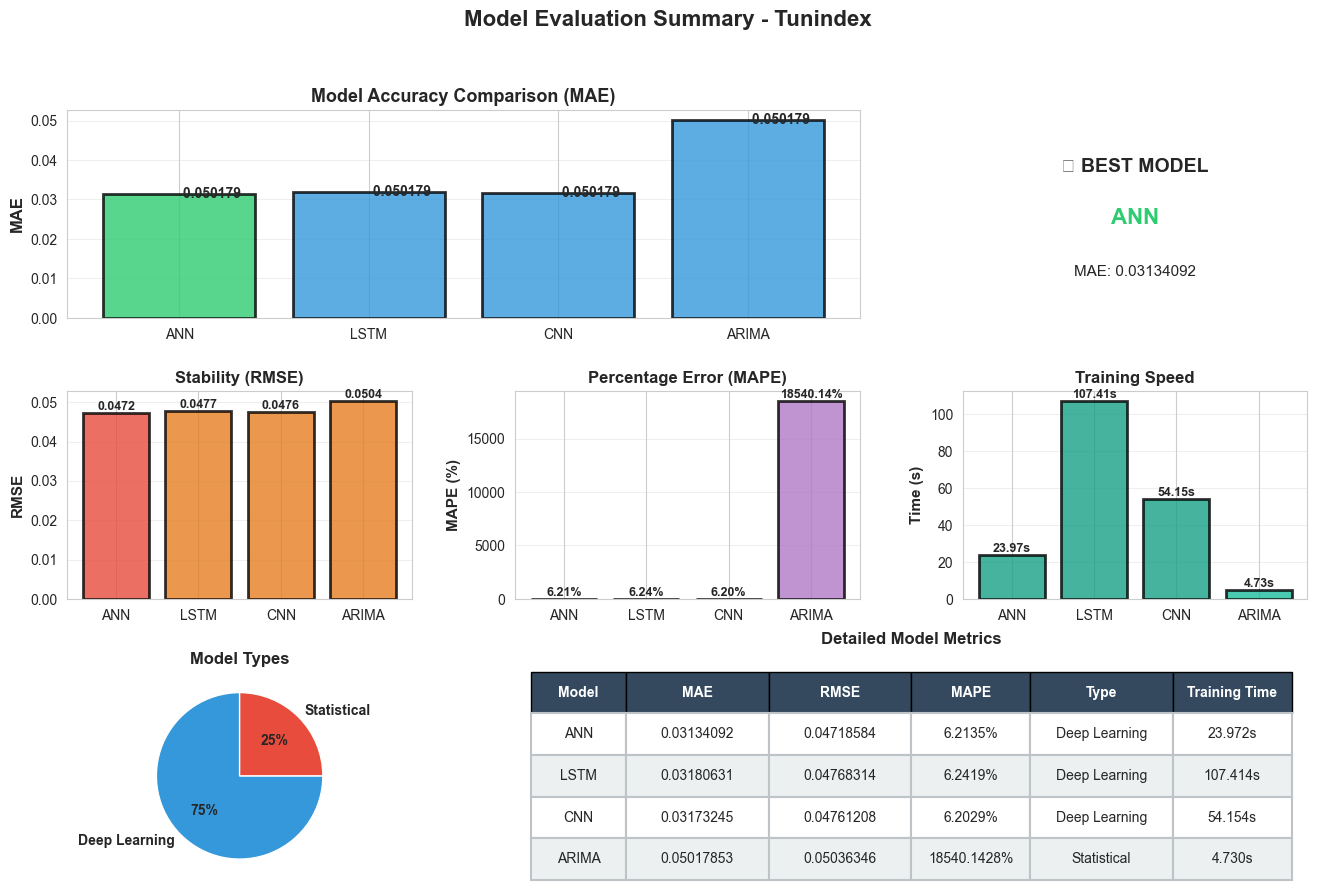


✓ Comprehensive evaluation image saved as 'model_evaluation_comparison.png'


In [48]:
# ==================== VISUAL MODEL COMPARISON ====================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. MAE Comparison
ax1 = fig.add_subplot(gs[0, :2])
colors_mae = ['#2ecc71' if x == eval_df['MAE'].min() else '#3498db' for x in eval_df['MAE']]
bars1 = ax1.bar(eval_df['Model'], eval_df['MAE'], color=colors_mae, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('MAE', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison (MAE)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f' {v:.6f}', va='center', fontweight='bold')

# 2. Best Model Indicator
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
best_model = eval_df.loc[eval_df['MAE'].idxmin(), 'Model']
best_mae = eval_df['MAE'].min()
ax2.text(0.5, 0.7, '🏆 BEST MODEL', ha='center', fontsize=14, fontweight='bold', transform=ax2.transAxes)
ax2.text(0.5, 0.45, best_model, ha='center', fontsize=16, fontweight='bold', color='#2ecc71', transform=ax2.transAxes)
ax2.text(0.5, 0.2, f'MAE: {best_mae:.8f}', ha='center', fontsize=11, transform=ax2.transAxes)

# 3. RMSE Comparison
ax3 = fig.add_subplot(gs[1, 0])
colors_rmse = ['#e74c3c' if x == eval_df['RMSE'].min() else '#e67e22' for x in eval_df['RMSE']]
bars3 = ax3.bar(eval_df['Model'], eval_df['RMSE'], color=colors_rmse, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax3.set_title('Stability (RMSE)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{eval_df.iloc[i]["RMSE"]:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 4. MAPE Comparison
ax4 = fig.add_subplot(gs[1, 1])
colors_mape = ['#9b59b6' if x == eval_df['MAPE (%)'].min() else '#af7ac5' for x in eval_df['MAPE (%)']]
bars4 = ax4.bar(eval_df['Model'], eval_df['MAPE (%)'], color=colors_mape, alpha=0.8, edgecolor='black', linewidth=2)
ax4.set_ylabel('MAPE (%)', fontsize=11, fontweight='bold')
ax4.set_title('Percentage Error (MAPE)', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{eval_df.iloc[i]["MAPE (%)"]:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 5. Training Time
ax5 = fig.add_subplot(gs[1, 2])
colors_time = ['#1abc9c' if x == eval_df['Training Time (s)'].min() else '#16a085' for x in eval_df['Training Time (s)']]
bars5 = ax5.bar(eval_df['Model'], eval_df['Training Time (s)'], color=colors_time, alpha=0.8, edgecolor='black', linewidth=2)
ax5.set_ylabel('Time (s)', fontsize=11, fontweight='bold')
ax5.set_title('Training Speed', fontsize=12, fontweight='bold')
ax5.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{eval_df.iloc[i]["Training Time (s)"]:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)

# 6. Type Distribution
ax6 = fig.add_subplot(gs[2, 0])
type_counts = eval_df['Type'].value_counts()
colors_type = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax6.pie(type_counts.values, labels=type_counts.index, autopct='%1.0f%%',
                                     colors=colors_type, startangle=90, textprops={'fontsize': 10, 'fontweight': 'bold'})
ax6.set_title('Model Types', fontsize=12, fontweight='bold')

# 7. Detailed Metrics Table
ax7 = fig.add_subplot(gs[2, 1:])
ax7.axis('tight')
ax7.axis('off')

table_data = []
for idx, row in eval_df.iterrows():
    table_data.append([
        row['Model'],
        f"{row['MAE']:.8f}",
        f"{row['RMSE']:.8f}",
        f"{row['MAPE (%)']:.4f}%",
        row['Type'],
        f"{row['Training Time (s)']:.3f}s"
    ])

table = ax7.table(cellText=table_data,
                  colLabels=['Model', 'MAE', 'RMSE', 'MAPE', 'Type', 'Training Time'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.12, 0.18, 0.18, 0.15, 0.18, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(6):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style rows
for i in range(1, len(table_data) + 1):
    for j in range(6):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].set_edgecolor('#bdc3c7')
        table[(i, j)].set_linewidth(1.5)

ax7.set_title('Detailed Model Metrics', fontsize=12, fontweight='bold', pad=20)

# Main title
fig.suptitle(f'Model Evaluation Summary - {index}', fontsize=16, fontweight='bold', y=0.98)

plt.savefig('model_evaluation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comprehensive evaluation image saved as 'model_evaluation_comparison.png'")

In [49]:
# ==================== FINAL RECOMMENDATIONS ====================

print("\n" + "=" * 140)
print("FINAL RECOMMENDATIONS & CONCLUSIONS")
print("=" * 140 + "\n")

best_model_name = eval_df.loc[eval_df['MAE'].idxmin(), 'Model']
best_metrics = eval_df.loc[eval_df['MAE'].idxmin()]

print(f"✓ BEST PERFORMING MODEL: {best_model_name}")
print(f"  └─ MAE:  {best_metrics['MAE']:.8f}")
print(f"  └─ RMSE: {best_metrics['RMSE']:.8f}")
print(f"  └─ MAPE: {best_metrics['MAPE (%)']:.4f}%")
print(f"  └─ Training Time: {best_metrics['Training Time (s)']:.3f}s\n")

print("📌 MODEL-SPECIFIC INSIGHTS:\n")

print(f"ANN (Artificial Neural Network)")
print(f"  • MAE: {metrics_ann['MAE']:.8f}")
print(f"  • Rank: #{eval_df[eval_df['Model'] == 'ANN'].index[0] + 1}")
print(f"  • Best for: Non-linear pattern recognition\n")

print(f"LSTM (Long Short-Term Memory)")
print(f"  • MAE: {metrics_lstm['MAE']:.8f}")
print(f"  • Rank: #{eval_df[eval_df['Model'] == 'LSTM'].index[0] + 1}")
print(f"  • Best for: Temporal dependencies and sequential patterns\n")

print(f"CNN (Convolutional Neural Network)")
print(f"  • MAE: {metrics_cnn['MAE']:.8f}")
print(f"  • Rank: #{eval_df[eval_df['Model'] == 'CNN'].index[0] + 1}")
print(f"  • Best for: Feature extraction from time series\n")

print(f"ARIMA (AutoRegressive Integrated Moving Average)")
print(f"  • MAE: {metrics_arima['MAE']:.8f}")
print(f"  • Rank: #{eval_df[eval_df['Model'] == 'ARIMA'].index[0] + 1}")
print(f"  • Best for: Interpretable, lightweight forecasting\n")

print("💡 DEPLOYMENT RECOMMENDATIONS:\n")
print("1️⃣  For Production (Accuracy Priority):")
print(f"    → Use {best_model_name} model")
print(f"    → Expected MAE: {best_metrics['MAE']:.8f}\n")

print("2️⃣  For Regulatory Compliance:")
print("    → Use ARIMA (highly interpretable)")
print("    → Easy to document and explain\n")

print("3️⃣  For Hybrid Approach:")
print("    → Ensemble: Average predictions from top 2 models")
print("    → Reduces model-specific bias\n")

print("=" * 140 + "\n")


FINAL RECOMMENDATIONS & CONCLUSIONS

✓ BEST PERFORMING MODEL: ANN
  └─ MAE:  0.03134092
  └─ RMSE: 0.04718584
  └─ MAPE: 6.2135%
  └─ Training Time: 23.972s

📌 MODEL-SPECIFIC INSIGHTS:

ANN (Artificial Neural Network)
  • MAE: 0.03134092
  • Rank: #1
  • Best for: Non-linear pattern recognition

LSTM (Long Short-Term Memory)
  • MAE: 0.03180631
  • Rank: #2
  • Best for: Temporal dependencies and sequential patterns

CNN (Convolutional Neural Network)
  • MAE: 0.03173245
  • Rank: #3
  • Best for: Feature extraction from time series

ARIMA (AutoRegressive Integrated Moving Average)
  • MAE: 0.05017853
  • Rank: #4
  • Best for: Interpretable, lightweight forecasting

💡 DEPLOYMENT RECOMMENDATIONS:

1️⃣  For Production (Accuracy Priority):
    → Use ANN model
    → Expected MAE: 0.03134092

2️⃣  For Regulatory Compliance:
    → Use ARIMA (highly interpretable)
    → Easy to document and explain

3️⃣  For Hybrid Approach:
    → Ensemble: Average predictions from top 2 models
    → Reduce